# Import the necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model, Sequential
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding,Bidirectional, TimeDistributed,GlobalMaxPool1D,Masking
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
import json
from sklearn.model_selection import KFold
%matplotlib inline

### Load the data into Pandas dataframe

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Drop the columns that are not required for the neural network.

In [ ]:
with open('/content/drive/My Drive/max-labels-intense-selection.json', 'r', encoding='utf-8') as file:
    data = json.load(file)

In [ ]:
X = ([x[0] for x in data])

y = np.array([x[1] for x in data])


Understand the distribution better.

* Create input and output vectors.
* Process the labels.

In [ ]:
X = X
Y = y
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

Split into training and test data.

### Process the data
* Tokenize the data and convert the text to sequences.
* Add padding to ensure that all the sequences have the same shape.
* There are many ways of taking the *max_len* and here an arbitrary length of 150 is chosen.

In [ ]:
max_words = 10000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X)
sequences = tok.texts_to_sequences(X)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

RNN with GRU

In [ ]:
from keras import layers, models, optimizers
embedding_matrix = np.zeros((len(tok.word_index) + 1, 256))
def rnn_gru():
  input_layer = layers.Input((max_len, ))
  # Add the word embedding Layer
  embedding_layer = layers.Embedding(len(tok.word_index) + 1, 256, weights=[embedding_matrix], trainable=False)(input_layer)
  embedding_layer = layers.SpatialDropout1D(0.2)(embedding_layer)
  # Add the GRU Layer
  lstm_layer = layers.GRU(256)(embedding_layer) 
  
  #embedding_layer = layers.SpatialDropout1D(0.2)(lstm_layer)

  lstm_layer = layers.GRU(256)(embedding_layer) 
  # Add the output Layers
  output_layer1 = layers.Dense(1, activation="relu")(lstm_layer)
  output_layer1 = layers.Dropout(0.2)(output_layer1)
  output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)
  # Compile the model
  model = models.Model(inputs=input_layer, outputs=output_layer2)
  model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy',metrics=['accuracy'])
  return model

In [ ]:
mod = rnn_gru()
history = mod.fit(sequences_matrix, Y,validation_split=0.2, batch_size=128, epochs=10)

Epoch 1/10
125/125 [==============================] - 4s 30ms/step - loss: 0.6931 - accuracy: 0.5003 - val_loss: 0.6933 - val_accuracy: 0.4843
Epoch 2/10
125/125 [==============================] - 3s 27ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4843
Epoch 3/10
125/125 [==============================] - 3s 26ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6934 - val_accuracy: 0.4843
Epoch 4/10
125/125 [==============================] - 3s 26ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6934 - val_accuracy: 0.4843
Epoch 5/10
125/125 [==============================] - 3s 26ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6933 - val_accuracy: 0.4843
Epoch 6/10
125/125 [==============================] - 3s 26ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6934 - val_accuracy: 0.4843
Epoch 7/10
125/125 [==============================] - 3s 27ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6935 - val_accuracy: 0.4843

In [ ]:
loss, accuracy = mod.evaluate(sequences_matrix, Y)
print('Accuracy: %f' % (accuracy*100))

625/625 [==============================] - 4s 7ms/step - loss: 0.6932 - accuracy: 0.5000
Accuracy: 50.000000


rnn with cnn layer

In [ ]:
from keras.layers import Convolution1D
embedding_matrix = np.zeros((len(tok.word_index) + 1, 300))

def rnn_cnn():
  # Add an Input Layer
  input_layer = layers.Input((max_len, ))
  
  # Add the word embedding Layer
  embedding_layer = layers.Embedding(len(tok.word_index) + 1, 300, weights=[embedding_matrix], trainable=False)(input_layer)
  embedding_layer = layers.SpatialDropout1D(0.3)(embedding_layer)
  
  # Add the recurrent layer
  rnn_layer = layers.Bidirectional(layers.GRU(50, return_sequences=True))(embedding_layer)
    
  # Add the convolutional Layer
  conv_layer = layers.Convolution1D(100, 3, activation="relu")(embedding_layer)
  
  # Add the pooling Layer
  pooling_layer = layers.GlobalMaxPool1D()(conv_layer)
  
  # Add the output Layers
  output_layer1 = layers.Dense(50, activation="relu")(pooling_layer)
  output_layer1 = layers.Dropout(0.2)(output_layer1)
  output_layer2 = layers.Dense(1, activation="sigmoid")(output_layer1)

  # Compile the model
  model = models.Model(inputs=input_layer, outputs=output_layer2)
  model.compile(optimizer=optimizers.Adam(), loss='binary_crossentropy',metrics=['accuracy'])
    
  return model


In [ ]:
mod = rnn_cnn()
history = mod.fit(sequences_matrix, Y,validation_split=0.2, batch_size=128, epochs=10)

Epoch 1/10
125/125 [==============================] - 2s 12ms/step - loss: 0.6931 - accuracy: 0.4992 - val_loss: 0.6933 - val_accuracy: 0.4843
Epoch 2/10
125/125 [==============================] - 1s 11ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6934 - val_accuracy: 0.4843
Epoch 3/10
125/125 [==============================] - 1s 12ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6934 - val_accuracy: 0.4843
Epoch 4/10
125/125 [==============================] - 1s 11ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6934 - val_accuracy: 0.4843
Epoch 5/10
125/125 [==============================] - 1s 11ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6934 - val_accuracy: 0.4843
Epoch 6/10
125/125 [==============================] - 1s 11ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6935 - val_accuracy: 0.4843
Epoch 7/10
125/125 [==============================] - 1s 11ms/step - loss: 0.6931 - accuracy: 0.5039 - val_loss: 0.6935 - val_accuracy: 0.4843

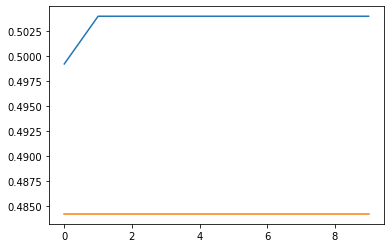

In [ ]:
plt.plot(history.history['accuracy'], label='MAE (training data)')
plt.plot(history.history['val_accuracy'], label='MAE (validation data)')
plt.show()

In [ ]:
loss, accuracy = mod.evaluate(sequences_matrix, Y)
print('Accuracy: %f' % (accuracy*100))

625/625 [==============================] - 2s 4ms/step - loss: 0.6932 - accuracy: 0.5000
Accuracy: 50.000000


### RNN
Define the RNN structure.

In [ ]:
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = LSTM(64)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('relu')(layer)
    layer = Dropout(0.5)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('sigmoid')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

Call the function and compile the model.

In [ ]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          [(None, 150)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           500000    
_________________________________________________________________
lstm (LSTM)                  (None, 64)                29440     
_________________________________________________________________
FC1 (Dense)                  (None, 256)               16640     
_________________________________________________________________
activation (Activation)      (None, 256)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
out_layer (Dense)            (None, 1)                

Fit on the training data.

In [ ]:
history = model.fit(sequences_matrix, Y,validation_split=0.2, batch_size=128, epochs=10)

Epoch 1/10
125/125 [==============================] - 2s 20ms/step - loss: 0.5492 - accuracy: 0.7328 - val_loss: 0.5116 - val_accuracy: 0.7655
Epoch 2/10
125/125 [==============================] - 2s 17ms/step - loss: 0.4692 - accuracy: 0.7849 - val_loss: 0.5412 - val_accuracy: 0.7385
Epoch 3/10
125/125 [==============================] - 2s 16ms/step - loss: 0.4056 - accuracy: 0.8207 - val_loss: 0.5308 - val_accuracy: 0.7660
Epoch 4/10
125/125 [==============================] - 2s 16ms/step - loss: 0.3637 - accuracy: 0.8440 - val_loss: 0.5356 - val_accuracy: 0.7580
Epoch 5/10
125/125 [==============================] - 2s 16ms/step - loss: 0.3332 - accuracy: 0.8554 - val_loss: 0.5516 - val_accuracy: 0.7523
Epoch 6/10
125/125 [==============================] - 2s 16ms/step - loss: 0.3047 - accuracy: 0.8723 - val_loss: 0.5456 - val_accuracy: 0.7508
Epoch 7/10
125/125 [==============================] - 2s 16ms/step - loss: 0.2730 - accuracy: 0.8864 - val_loss: 0.6447 - val_accuracy: 0.7303

The model performs well on the validation set and this configuration is chosen as the final model.

Process the test set data.

Evaluate the model on the test set.

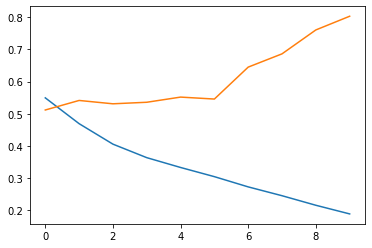

In [ ]:
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(sequences_matrix, Y)
print('Accuracy: %f' % (accuracy*100))

625/625 [==============================] - 4s 6ms/step - loss: 0.2746 - accuracy: 0.9026
Accuracy: 90.259999


In [ ]:
def BiDir():
  inp = Input(shape=[max_len])
  x = Embedding(max_words,50,input_length=max_len)(inp)
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.25, recurrent_dropout=0))(x)
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.25, recurrent_dropout=0))(x)
 # x = GlobalMaxPool1D()(x)
  x = Dense(256, activation="relu")(x)
  x = Dropout(0.2)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  return model

In [ ]:
model1 = BiDir()
model1.summary()
model1.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_3 (Embedding)      (None, 150, 50)           500000    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 512)          628736    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 150, 512)          1574912   
_________________________________________________________________
dense_4 (Dense)              (None, 150, 256)          131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 150, 256)          0         
_________________________________________________________________
dense_5 (Dense)              (None, 150, 1)           

In [ ]:
history = model1.fit(sequences_matrix, Y,validation_split=0.2, batch_size=128, epochs=100)

Epoch 1/100
125/125 [==============================] - 16s 131ms/step - loss: 0.6686 - accuracy: 0.6236 - val_loss: 0.5566 - val_accuracy: 0.7347
Epoch 2/100
125/125 [==============================] - 15s 117ms/step - loss: 0.5267 - accuracy: 0.7509 - val_loss: 0.5066 - val_accuracy: 0.7680
Epoch 3/100
125/125 [==============================] - 15s 119ms/step - loss: 0.4532 - accuracy: 0.8021 - val_loss: 0.5286 - val_accuracy: 0.7606
Epoch 4/100
125/125 [==============================] - 15s 118ms/step - loss: 0.4060 - accuracy: 0.8284 - val_loss: 0.5561 - val_accuracy: 0.7366
Epoch 5/100
125/125 [==============================] - 15s 118ms/step - loss: 0.3763 - accuracy: 0.8434 - val_loss: 0.5452 - val_accuracy: 0.7559
Epoch 6/100
125/125 [==============================] - 15s 118ms/step - loss: 0.3510 - accuracy: 0.8591 - val_loss: 0.5859 - val_accuracy: 0.7548
Epoch 7/100
125/125 [==============================] - 15s 118ms/step - loss: 0.3302 - accuracy: 0.8672 - val_loss: 0.5726 -

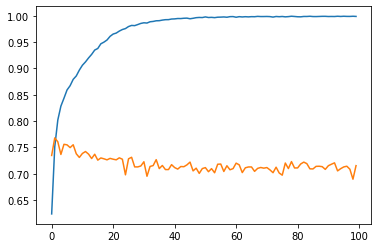

In [ ]:
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.show()

In [ ]:
loss, accuracy = model1.evaluate(sequences_matrix, Y)
print('Accuracy: %f' % (accuracy*100))

625/625 [==============================] - 14s 22ms/step - loss: 0.4786 - accuracy: 0.9430
Accuracy: 94.296396


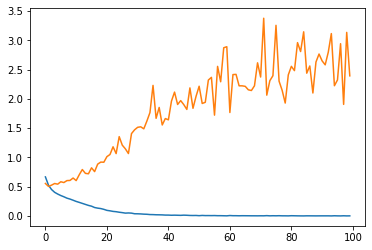

In [ ]:
plt.plot(history.history['loss'], label='MAE (training data)')
plt.plot(history.history['val_loss'], label='MAE (validation data)')
plt.show()

In [ ]:
def BiDir1():
  inp = Input(shape=[max_len])
  x = Embedding(max_words,50,input_length=max_len)(inp)
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.25, recurrent_dropout=0))(x)
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.25, recurrent_dropout=0))(x)
  x = Dense(256, activation="relu")(x)
  x = Dropout(0.2)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  return model

In [ ]:
model1 = BiDir1()
model1.summary()
model1.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 150, 50)           500000    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 150, 512)          628736    
_________________________________________________________________
bidirectional_4 (Bidirection (None, 150, 512)          1574912   
_________________________________________________________________
dense_6 (Dense)              (None, 150, 256)          131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 150, 256)          0         
_________________________________________________________________
dense_7 (Dense)              (None, 150, 1)           

In [ ]:
history = model1.fit(sequences_matrix, Y,validation_split=0.2, batch_size=128, epochs=100)

Epoch 1/100
125/125 [==============================] - 16s 131ms/step - loss: 0.6909 - accuracy: 0.6073 - val_loss: 0.5835 - val_accuracy: 0.7209
Epoch 2/100
125/125 [==============================] - 15s 118ms/step - loss: 0.5208 - accuracy: 0.7591 - val_loss: 0.5161 - val_accuracy: 0.7596
Epoch 3/100
125/125 [==============================] - 15s 118ms/step - loss: 0.4651 - accuracy: 0.7977 - val_loss: 0.5173 - val_accuracy: 0.7634
Epoch 4/100
125/125 [==============================] - 15s 118ms/step - loss: 0.4119 - accuracy: 0.8278 - val_loss: 0.5714 - val_accuracy: 0.7631
Epoch 5/100
125/125 [==============================] - 15s 119ms/step - loss: 0.3826 - accuracy: 0.8415 - val_loss: 0.5410 - val_accuracy: 0.7535
Epoch 6/100
125/125 [==============================] - 15s 119ms/step - loss: 0.3572 - accuracy: 0.8544 - val_loss: 0.5635 - val_accuracy: 0.7536
Epoch 7/100
125/125 [==============================] - 15s 119ms/step - loss: 0.3297 - accuracy: 0.8703 - val_loss: 0.6265 -

In [ ]:
loss, accuracy = model1.evaluate(sequences_matrix, Y)
print('Accuracy: %f' % (accuracy*100))

625/625 [==============================] - 14s 22ms/step - loss: 0.5897 - accuracy: 0.9411
Accuracy: 94.114608


KFold

In [ ]:

from sklearn.model_selection import KFold

num_folds = 10

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
for train, test in kfold.split(sequences_matrix,Y):
  inp = Input(shape=[max_len])
  x = Embedding(max_words,50,input_length=max_len)(inp)
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = GlobalMaxPool1D()(x)
  x = Dense(256, activation="relu")(x)
  x = Dropout(0.2)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(sequences_matrix[train], Y[train],
              batch_size=128,
              epochs=10)
  
  scores = model.evaluate(sequences_matrix[test], Y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no+= 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
141/141 [==============================] - 6s 46ms/step - loss: 0.5619 - accuracy: 0.7191
Epoch 2/10
141/141 [==============================] - 6s 46ms/step - loss: 0.4692 - accuracy: 0.7853
Epoch 3/10
141/141 [==============================] - 6s 45ms/step - loss: 0.4145 - accuracy: 0.8157
Epoch 4/10
141/141 [==============================] - 6s 45ms/step - loss: 0.3747 - accuracy: 0.8343
Epoch 5/10
141/141 [==============================] - 6s 45ms/step - loss: 0.3373 - accuracy: 0.8559
Epoch 6/10
141/141 [==============================] - 6s 45ms/step - loss: 0.3009 - accuracy: 0.8746
Epoch 7/10
141/141 [==============================] - 6s 46ms/step - loss: 0.2674 - accuracy: 0.8889
Epoch 8/10
141/141 [==============================] - 6s 46ms/step - loss: 0.2305 - accuracy: 0.9068
Epoch 9/10
141/141 [==============================] - 6s 46ms/step - loss: 0.2000 - accuracy: 0

KFold with validation accuracy

In [ ]:
from sklearn.model_selection import KFold

num_folds = 10

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
for train, test in kfold.split(sequences_matrix,Y):
  inp = Input(shape=[max_len])
  x = Embedding(max_words,50,input_length=max_len)(inp)
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = GlobalMaxPool1D()(x)
  x = Dense(256, activation="relu")(x)
  x = Dropout(0.2)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(sequences_matrix[train], Y[train],validation_split=0.2,
              batch_size=128,
              epochs=10)
  
  scores = model.evaluate(sequences_matrix[test], Y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no+= 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
113/113 [==============================] - 7s 58ms/step - loss: 0.5816 - accuracy: 0.7212 - val_loss: 0.5088 - val_accuracy: 0.7614
Epoch 2/10
113/113 [==============================] - 6s 51ms/step - loss: 0.4669 - accuracy: 0.7873 - val_loss: 0.5297 - val_accuracy: 0.7539
Epoch 3/10
113/113 [==============================] - 6s 51ms/step - loss: 0.4044 - accuracy: 0.8235 - val_loss: 0.5129 - val_accuracy: 0.7625
Epoch 4/10
113/113 [==============================] - 6s 51ms/step - loss: 0.3666 - accuracy: 0.8441 - val_loss: 0.5484 - val_accuracy: 0.7403
Epoch 5/10
113/113 [==============================] - 6s 51ms/step - loss: 0.3326 - accuracy: 0.8592 - val_loss: 0.6092 - val_accuracy: 0.7400
Epoch 6/10
113/113 [==============================] - 6s 51ms/step - loss: 0.3007 - accuracy: 0.8765 - val_loss: 0.5776 - val_accuracy: 0.7522
Epoch 7/10
113/113 [=========================

KFold with fold = 5

In [ ]:
from sklearn.model_selection import KFold

num_folds = 5

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
for train, test in kfold.split(sequences_matrix,Y):
  inp = Input(shape=[max_len])
  x = Embedding(max_words,50,input_length=max_len)(inp)
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = GlobalMaxPool1D()(x)
  x = Dense(256, activation="relu")(x)
  x = Dropout(0.2)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(sequences_matrix[train], Y[train],validation_split=0.2,
              batch_size=128,
              epochs=10)
  
  scores = model.evaluate(sequences_matrix[test], Y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])

  # Increase fold number
  fold_no+= 1

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
100/100 [==============================] - 6s 55ms/step - loss: 0.0270 - accuracy: 0.5022 - val_loss: 0.0146 - val_accuracy: 0.4822
Epoch 2/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0144 - accuracy: 0.5059 - val_loss: 0.0146 - val_accuracy: 0.4822
Epoch 3/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0141 - accuracy: 0.5059 - val_loss: 0.0143 - val_accuracy: 0.4822
Epoch 4/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0138 - accuracy: 0.5059 - val_loss: 0.0143 - val_accuracy: 0.4822
Epoch 5/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0137 - accuracy: 0.5059 - val_loss: 0.0144 - val_accuracy: 0.4822
Epoch 6/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0136 - accuracy: 0.5059 - val_loss: 0.0144 - val_accuracy: 0.4822
Epoch 7/10
100/100 [=========================

Plotting KFold with fold = 5 

------------------------------------------------------------------------
Training for fold 1 ...
Epoch 1/10
100/100 [==============================] - 6s 56ms/step - loss: 0.0266 - accuracy: 0.5016 - val_loss: 0.0146 - val_accuracy: 0.4744
Epoch 2/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0142 - accuracy: 0.5016 - val_loss: 0.0148 - val_accuracy: 0.4744
Epoch 3/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0141 - accuracy: 0.5016 - val_loss: 0.0146 - val_accuracy: 0.4744
Epoch 4/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0139 - accuracy: 0.5016 - val_loss: 0.0146 - val_accuracy: 0.4744
Epoch 5/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0138 - accuracy: 0.5016 - val_loss: 0.0145 - val_accuracy: 0.4744
Epoch 6/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0137 - accuracy: 0.5016 - val_loss: 0.0146 - val_accuracy: 0.4744
Epoch 7/10
100/100 [=========================

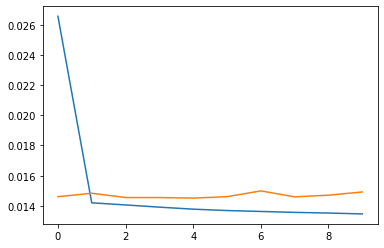

------------------------------------------------------------------------
Training for fold 2 ...
Epoch 1/10
100/100 [==============================] - 6s 55ms/step - loss: 0.0269 - accuracy: 0.5007 - val_loss: 0.0147 - val_accuracy: 0.4844
Epoch 2/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0143 - accuracy: 0.5017 - val_loss: 0.0144 - val_accuracy: 0.4844
Epoch 3/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0140 - accuracy: 0.5017 - val_loss: 0.0145 - val_accuracy: 0.4844
Epoch 4/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0139 - accuracy: 0.5017 - val_loss: 0.0142 - val_accuracy: 0.4844
Epoch 5/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0137 - accuracy: 0.5017 - val_loss: 0.0142 - val_accuracy: 0.4844
Epoch 6/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0137 - accuracy: 0.5017 - val_loss: 0.0145 - val_accuracy: 0.4844
Epoch 7/10
100/100 [=========================

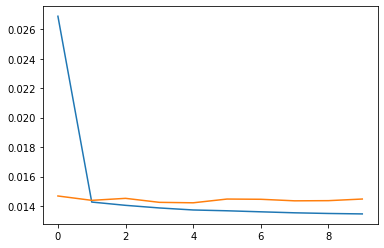

------------------------------------------------------------------------
Training for fold 3 ...
Epoch 1/10
100/100 [==============================] - 6s 56ms/step - loss: 0.0268 - accuracy: 0.5021 - val_loss: 0.0142 - val_accuracy: 0.4900
Epoch 2/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0144 - accuracy: 0.5065 - val_loss: 0.0142 - val_accuracy: 0.4900
Epoch 3/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0142 - accuracy: 0.5065 - val_loss: 0.0141 - val_accuracy: 0.4900
Epoch 4/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0139 - accuracy: 0.5065 - val_loss: 0.0142 - val_accuracy: 0.4900
Epoch 5/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0138 - accuracy: 0.5065 - val_loss: 0.0141 - val_accuracy: 0.4900
Epoch 6/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0137 - accuracy: 0.5065 - val_loss: 0.0141 - val_accuracy: 0.4900
Epoch 7/10
100/100 [=========================

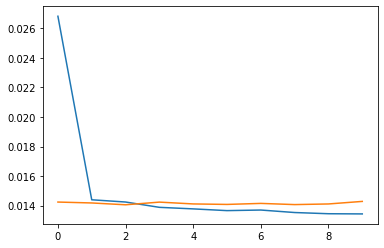

------------------------------------------------------------------------
Training for fold 4 ...
Epoch 1/10
100/100 [==============================] - 6s 56ms/step - loss: 0.0275 - accuracy: 0.4998 - val_loss: 0.0174 - val_accuracy: 0.4831
Epoch 2/10
100/100 [==============================] - 5s 49ms/step - loss: 0.0145 - accuracy: 0.5056 - val_loss: 0.0150 - val_accuracy: 0.4831
Epoch 3/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0141 - accuracy: 0.5056 - val_loss: 0.0143 - val_accuracy: 0.4831
Epoch 4/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0139 - accuracy: 0.5056 - val_loss: 0.0142 - val_accuracy: 0.4831
Epoch 5/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0138 - accuracy: 0.5056 - val_loss: 0.0143 - val_accuracy: 0.4831
Epoch 6/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0137 - accuracy: 0.5056 - val_loss: 0.0143 - val_accuracy: 0.4831
Epoch 7/10
100/100 [=========================

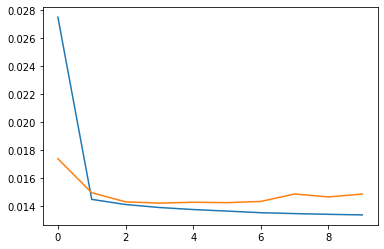

------------------------------------------------------------------------
Training for fold 5 ...
Epoch 1/10
100/100 [==============================] - 6s 56ms/step - loss: 0.0273 - accuracy: 0.5041 - val_loss: 0.0145 - val_accuracy: 0.4900
Epoch 2/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0142 - accuracy: 0.5041 - val_loss: 0.0157 - val_accuracy: 0.4900
Epoch 3/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0141 - accuracy: 0.5041 - val_loss: 0.0141 - val_accuracy: 0.4900
Epoch 4/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0139 - accuracy: 0.5041 - val_loss: 0.0141 - val_accuracy: 0.4900
Epoch 5/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0138 - accuracy: 0.5041 - val_loss: 0.0142 - val_accuracy: 0.4900
Epoch 6/10
100/100 [==============================] - 5s 50ms/step - loss: 0.0136 - accuracy: 0.5041 - val_loss: 0.0142 - val_accuracy: 0.4900
Epoch 7/10
100/100 [=========================

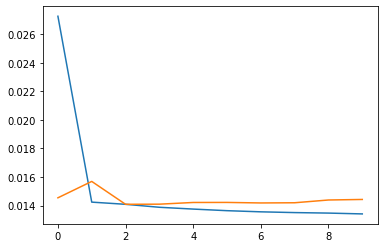

In [ ]:
from sklearn.model_selection import KFold

num_folds = 5

# Define per-fold score containers <-- these are new
acc_per_fold = []
loss_per_fold = []

kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
for train, test in kfold.split(sequences_matrix,Y):
  inp = Input(shape=[max_len])
  x = Embedding(max_words,50,input_length=max_len)(inp)
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = GlobalMaxPool1D()(x)
  x = Dense(256, activation="relu")(x)
  x = Dropout(0.2)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  model.compile(loss='binary_crossentropy',
                optimizer=RMSprop(),
                metrics=['accuracy'])
  print('------------------------------------------------------------------------')
  print(f'Training for fold {fold_no} ...')

  # Fit data to model
  history = model.fit(sequences_matrix[train], Y[train],validation_split=0.2,
              batch_size=128,
              epochs=10)
  
  scores = model.evaluate(sequences_matrix[test], Y[test], verbose=0)
  print(f'Score for fold {fold_no}: {model.metrics_names[0]} of {scores[0]}; {model.metrics_names[1]} of {scores[1]*100}%')
  acc_per_fold.append(scores[1] * 100)
  loss_per_fold.append(scores[0])
  plt.plot(history.history['loss'], label='MAE (training data)')
  plt.plot(history.history['val_loss'], label='MAE (validation data)')
  plt.show()

  # Increase fold number
  fold_no+= 1

BiDirectional LSTM with some variations

In [ ]:
def BiDir2():
  inp = Input(shape=[max_len])
  x = Embedding(max_words,50,input_length=max_len)(inp)
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = GlobalMaxPool1D()(x)
  x = Dense(256, activation="relu")(x)
  x = Dropout(0.2)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  return model

In [ ]:
model2 = BiDir2()
model2.summary()
model2.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 150, 50)           500000    
_________________________________________________________________
bidirectional (Bidirectional (None, 150, 512)          628736    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 150, 512)          1574912   
_________________________________________________________________
global_max_pooling1d (Global (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dropout (Dropout)            (None, 256)              

In [ ]:
history = model2.fit(sequences_matrix, Y,validation_split=0.2, batch_size=128, epochs=10)

Epoch 1/10
125/125 [==============================] - 23s 183ms/step - loss: 0.5763 - accuracy: 0.7202 - val_loss: 0.5181 - val_accuracy: 0.7653
Epoch 2/10
125/125 [==============================] - 22s 173ms/step - loss: 0.4782 - accuracy: 0.7824 - val_loss: 0.4973 - val_accuracy: 0.7703
Epoch 3/10
125/125 [==============================] - 22s 174ms/step - loss: 0.4140 - accuracy: 0.8176 - val_loss: 0.4986 - val_accuracy: 0.7673
Epoch 4/10
125/125 [==============================] - 22s 173ms/step - loss: 0.3731 - accuracy: 0.8386 - val_loss: 0.5022 - val_accuracy: 0.7642
Epoch 5/10
125/125 [==============================] - 22s 173ms/step - loss: 0.3412 - accuracy: 0.8548 - val_loss: 0.5450 - val_accuracy: 0.7575
Epoch 6/10
125/125 [==============================] - 22s 174ms/step - loss: 0.3044 - accuracy: 0.8715 - val_loss: 0.5947 - val_accuracy: 0.7515
Epoch 7/10
125/125 [==============================] - 22s 174ms/step - loss: 0.2647 - accuracy: 0.8869 - val_loss: 0.6414 - val_ac

In [ ]:
accr1 = model2.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr1[0],accr1[1]))

125/125 [==============================] - 2s 19ms/step - loss: 0.8256 - accuracy: 0.7215
Test set
  Loss: 0.826
  Accuracy: 0.721


In [ ]:
def BiDir3():
  inp = Input(shape=[max_len])
  x = Embedding(max_words,50,input_length=max_len)(inp)
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = Dense(256, activation="relu")(x)
  x = Dropout(0.2)(x)
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = Dense(256, activation="relu")(x)
  x = Dropout(0.2)(x)
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  return model

In [ ]:
model3 = BiDir3()
model3.summary()
model3.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_2 (Embedding)      (None, 150, 50)           500000    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 150, 512)          628736    
_________________________________________________________________
bidirectional_6 (Bidirection (None, 150, 512)          1574912   
_________________________________________________________________
dense_3 (Dense)              (None, 150, 256)          131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 150, 256)          0         
_________________________________________________________________
bidirectional_7 (Bidirection (None, 150, 512)         

In [ ]:
model3.fit(sequences_matrix, Y_train, batch_size=128, epochs=10)

Epoch 1/10
125/125 [==============================] - 33s 265ms/step - loss: 0.6455 - accuracy: 0.6453
Epoch 2/10
125/125 [==============================] - 33s 266ms/step - loss: 0.5792 - accuracy: 0.7129
Epoch 3/10
125/125 [==============================] - 33s 261ms/step - loss: 0.5284 - accuracy: 0.7487
Epoch 4/10
125/125 [==============================] - 33s 263ms/step - loss: 0.4722 - accuracy: 0.7937
Epoch 5/10
125/125 [==============================] - 33s 262ms/step - loss: 0.4312 - accuracy: 0.8209
Epoch 6/10
125/125 [==============================] - 33s 262ms/step - loss: 0.3932 - accuracy: 0.8389
Epoch 7/10
125/125 [==============================] - 33s 262ms/step - loss: 0.3724 - accuracy: 0.8501
Epoch 8/10
125/125 [==============================] - 33s 262ms/step - loss: 0.3402 - accuracy: 0.8638
Epoch 9/10
125/125 [==============================] - 33s 262ms/step - loss: 0.3133 - accuracy: 0.8773
Epoch 10/10
125/125 [==============================] - 33s 262ms/step - l

In [ ]:
accr1 = model3.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr1[0],accr1[1]))

125/125 [==============================] - 5s 39ms/step - loss: 0.6087 - accuracy: 0.7526
Test set
  Loss: 0.609
  Accuracy: 0.753


In [ ]:
def BiDir4():
  inp = Input(shape=[max_len])
  x = Embedding(max_words,50,input_length=max_len)(inp)
  
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = Dense(256, activation="relu")(x)
  x = Dropout(0.2)(x)
  
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = Dense(256, activation="relu")(x)
  x = Dropout(0.2)(x)
  
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = Dense(256, activation="relu")(x)
  x = Dropout(0.2)(x)

  
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  return model

In [ ]:
model4 = BiDir4()
model4.summary()
model4.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "functional_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_5 (Embedding)      (None, 150, 50)           500000    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 150, 512)          628736    
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 150, 512)          1574912   
_________________________________________________________________
dense_8 (Dense)              (None, 150, 256)          131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 150, 256)          0         
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 150, 512)         

In [ ]:
model4.fit(sequences_matrix, Y_train, batch_size=128, epochs=10)

Epoch 1/10
125/125 [==============================] - 50s 403ms/step - loss: 0.6837 - accuracy: 0.6108
Epoch 2/10
125/125 [==============================] - 50s 402ms/step - loss: 0.6668 - accuracy: 0.5651
Epoch 3/10
125/125 [==============================] - 50s 402ms/step - loss: 0.6928 - accuracy: 0.5012
Epoch 4/10
125/125 [==============================] - 50s 402ms/step - loss: 0.6936 - accuracy: 0.5000
Epoch 5/10
125/125 [==============================] - 50s 402ms/step - loss: 0.6943 - accuracy: 0.4978
Epoch 6/10
125/125 [==============================] - 50s 402ms/step - loss: 0.6320 - accuracy: 0.6565
Epoch 7/10
125/125 [==============================] - 50s 402ms/step - loss: 0.5915 - accuracy: 0.6712
Epoch 8/10
125/125 [==============================] - 50s 402ms/step - loss: 0.5474 - accuracy: 0.7484
Epoch 9/10
125/125 [==============================] - 50s 402ms/step - loss: 0.5604 - accuracy: 0.7255
Epoch 10/10
125/125 [==============================] - 50s 402ms/step - l

In [ ]:
accr1 = model4.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr1[0],accr1[1]))

125/125 [==============================] - 8s 62ms/step - loss: 0.6247 - accuracy: 0.6812
Test set
  Loss: 0.625
  Accuracy: 0.681


In [ ]:
def BiDir5():
  inp = Input(shape=[max_len])
  x = Embedding(max_words,50,input_length=max_len)(inp)
  
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = Dense(256, activation="relu")(x)
  x = Dropout(0.2)(x)
  
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = Dense(256, activation="relu")(x)
  x = Dropout(0.2)(x)
  
  x = Bidirectional(LSTM(256, return_sequences=True, dropout=0.2, recurrent_dropout=0))(x)
  x = Dense(256, activation="relu")(x)
  x = Dropout(0.2)(x)

  
  x = Dense(1, activation="sigmoid")(x)
  model = Model(inputs=inp, outputs=x)
  return model

In [ ]:
model5 = BiDir5()
model5.summary()
model5.compile(loss='binary_crossentropy',optimizer=RMSprop(),metrics=['accuracy'])

Model: "functional_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 150)]             0         
_________________________________________________________________
embedding_6 (Embedding)      (None, 150, 50)           500000    
_________________________________________________________________
bidirectional_21 (Bidirectio (None, 150, 512)          628736    
_________________________________________________________________
dense_12 (Dense)             (None, 150, 256)          131328    
_________________________________________________________________
dropout_9 (Dropout)          (None, 150, 256)          0         
_________________________________________________________________
bidirectional_22 (Bidirectio (None, 150, 512)          1050624   
_________________________________________________________________
dense_13 (Dense)             (None, 150, 256)         

In [ ]:
model5.fit(sequences_matrix, Y_train, batch_size=128, epochs=10)

Epoch 1/10
125/125 [==============================] - 22s 175ms/step - loss: 0.6848 - accuracy: 0.5910
Epoch 2/10
125/125 [==============================] - 23s 180ms/step - loss: 0.5570 - accuracy: 0.7344
Epoch 3/10
125/125 [==============================] - 22s 178ms/step - loss: 0.5385 - accuracy: 0.7544
Epoch 4/10
125/125 [==============================] - 22s 176ms/step - loss: 0.4702 - accuracy: 0.7904
Epoch 5/10
125/125 [==============================] - 22s 176ms/step - loss: 0.4336 - accuracy: 0.8209
Epoch 6/10
125/125 [==============================] - 22s 176ms/step - loss: 0.4302 - accuracy: 0.8173
Epoch 7/10
125/125 [==============================] - 22s 175ms/step - loss: 0.3841 - accuracy: 0.8459
Epoch 8/10
125/125 [==============================] - 22s 176ms/step - loss: 0.3798 - accuracy: 0.8547
Epoch 9/10
125/125 [==============================] - 22s 177ms/step - loss: 0.3373 - accuracy: 0.8709
Epoch 10/10
125/125 [==============================] - 22s 177ms/step - l

In [ ]:
accr1 = model5.evaluate(test_sequences_matrix,Y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr1[0],accr1[1]))

125/125 [==============================] - 3s 27ms/step - loss: 0.6177 - accuracy: 0.7483
Test set
  Loss: 0.618
  Accuracy: 0.748
